# Time Series Project - Main Code Notebook

In [19]:
import pandas as pd 
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_style("darkgrid")

## Part 1 - Data EDA 

In [4]:
df = pd.read_csv("data/pollution_and_new_cars_unified.csv")

In [18]:
# split the unified dataset to data on air pollution and data on cars registration
df['date'] = pd.to_datetime(df['date'])
co_levels = df.drop("car_num", axis = 1)
co_levels = pd.melt(co_levels, id_vars='date', var_name='station', value_name='CO')
cars = df.loc[:, ['date','car_num']]

### Missing Values Analysis

In [29]:
daily_co

,date,station,CO
0,01/01/2010,Jerusalem_Bar_Ilan,0.8
1,02/01/2010,Jerusalem_Bar_Ilan,0.8
2,03/01/2010,Jerusalem_Bar_Ilan,NaN
3,04/01/2010,Jerusalem_Bar_Ilan,0.7
4,05/01/2010,Jerusalem_Bar_Ilan,0.7
...,...,...,...
33229,25/02/2025,Ranana_Ahuza,0.2
33230,26/02/2025,Ranana_Ahuza,0.3
33231,27/02/2025,Ranana_Ahuza,0.3
33232,28/02/2025,Ranana_Ahuza,0.3


In [34]:
# for the missing data part we use daily data instead of the half-monthly aggregation. The data can be found in our project github
daily_co = pd.read_csv("data/co_daily_clean.csv")
daily_co['date'] = daily_co['date'].astype("datetime64[ns]")

In [58]:
tmp = daily_co.groupby([daily_co['date'].dt.year, 'station'])['CO'].sum()

In [62]:

# aggregate missing values by year
nan_by_year_station = daily_co.groupby([daily_co['date'].dt.year, 
                      'station'])['CO'].apply(lambda x: x.isna().sum()).reset_index(name = "NaN Count")
nan_by_year_mean = nan_by_year_station.groupby("date")["NaN Count"].mean().reset_index(name = "NaN Count")

# aggregate missing values each month
nan_by_date = (
    daily_co.groupby([daily_co['date'].dt.year, daily_co['date'].dt.month, 'station'])['CO']
    .apply(lambda x: x.isna().sum())
    .rename_axis(['Year','Month', 'station'])
    .reset_index(name="NaN Count")
)
nan_by_date['date'] = pd.to_datetime(nan_by_date[['Year','Month']].assign(day=1))
nan_by_date.drop(["Year","Month"], axis=1, inplace=True)

nan_by_date_mean = (
  nan_by_date.groupby([nan_by_date['date'].dt.year, nan_by_date['date'].dt.month])['NaN Count']
 .mean()
 .rename_axis(['Year','Month'])
 .reset_index(name="NaN Count")
)
nan_by_date_mean['date'] = pd.to_datetime(nan_by_date_mean[['Year','Month']].assign(day=1))
nan_by_date_mean.drop(["Year","Month"], axis=1, inplace=True)

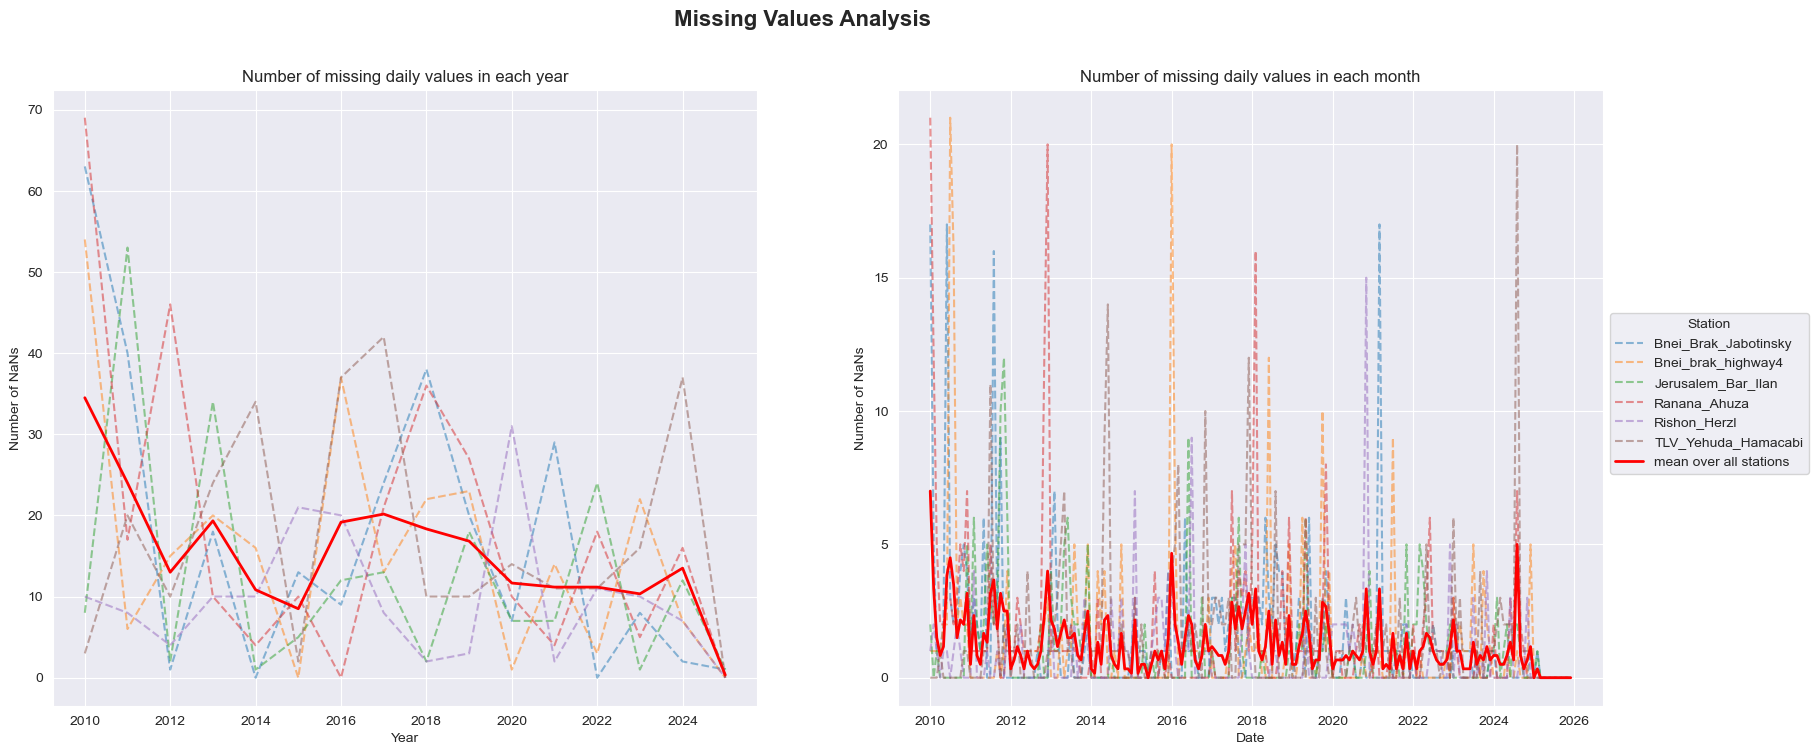

In [64]:
#plot both graphs

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.lineplot(ax = axes[0], data = nan_by_year_station, x='date', y='NaN Count', hue='station', alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[0], data = nan_by_year_mean, x = 'date', y='NaN Count', color = 'red', linewidth = 2, label="mean over all stations")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of NaNs")
axes[0].set_title("Number of missing daily values in each year")

sns.lineplot(ax = axes[1], data = nan_by_date, x='date', y='NaN Count', hue='station',  alpha = 0.5, linestyle='--')
sns.lineplot(ax = axes[1], data = nan_by_date_mean, x='date', y='NaN Count', color = 'red', linewidth = 2, label="mean over all stations")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Number of NaNs")
axes[1].set_title("Number of missing daily values in each month")

handles, labels = axes[1].get_legend_handles_labels()
axes[0].legend_.remove()
axes[1].legend_.remove()
fig.legend(handles, labels, title="Station", loc="center left", bbox_to_anchor=(0.9, 0.5))

fig.suptitle("Missing Values Analysis", fontsize=16, fontweight="bold")
# plt.savefig("visualizations/missing_values_analysis.png", dpi=300, bbox_inches='tight')

plt.show()